<h1 align="center">Advanced Image Processing and Analysis</h1>
<h3 align="center">ECE 4438B/ECE 9022/ECE 9202B/BIOMED 9519B/BIOPHYS 9519B/CAMI 9519B</h3>
<h4 align="center"><a href="mailto:echen29@uwo.ca?subject=Day 18: Mutual Information Lecture"> Elvis Chen, PhD, LL</a></h4>
<h4 align="center">Day 18, March 12, 2019</h4>

### Objective

In this Jupyter Notebook, we are going to examine the generic registration framework under SimpleITK.  It should be noted that the registration framework within ITK verion 3 and version 4 has changed slightly.  In the PDF class notes (Day 18), we depicted the registration framework for ITK (v3) as the following:

<img src="ITKv3_registration.png" width="850"/>

This *classical registration approach* is conceptually is easy to understand, and it is the approach taken by most of the registration platforms (OpenCV, Matlab, etc). 

#### Summary

To perform registration using SimpleITK:

1. Creating an instance of the registration framework requires selection of the following components:
  * Optimizer,
  * Similarity metric,
  * Interpolator.
2. The registration framework only support images with sitkFloat32 and sitkFloat64 pixel types. Use the SimpleITK [Cast()](http://www.itk.org/SimpleITKDoxygen/html/namespaceitk_1_1simple.html#af8c9d7cc96a299a05890e9c3db911885) function if the input image pixel type is something else,
3. Successful registration is highly dependent on initialization. In general one can:
  * use auxiliary information or user interaction to obtain an initial transformation (while avoiding resampling),
  * center the image using [CenteredTransform Initializer](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1CenteredTransformInitializerFilter.html),
  * Coarsely sample the parameter space using the [Exhaustive Optimizer](https://itk.org/Doxygen/html/classitk_1_1ExhaustiveOptimizerv4.html) to obtain one or more initial transformation estimates,
  * Manually initialize, via direct manipulation of transformation parameters and visualization or localization of corresponding points in the two images and then use [LandmarkBasedTransformInitializer](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1LandmarkBasedTransformInitializerFilter.html)

In [2]:
import SimpleITK as sitk

%run update_path_to_download_script
from downloaddata import fetch_data as fdata
import gui
import registration_gui as rgui
%matplotlib notebook

import numpy as np
import os
OUTPUT_DIR = 'output'

## Registration Components 

There are many options for creating an instance of the registration framework, all of which are configured in SimpleITK via methods of the <a href="http://www.itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1ImageRegistrationMethod.html">ImageRegistrationMethod</a> class. This class encapsulates many of the components available in ITK for constructing a registration instance.

Currently, the available choices from the following groups of ITK components are:

### Optimizers

The SimpleITK registration framework supports several optimizer types via the SetOptimizerAsX() methods, these include:

<ul>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1ExhaustiveOptimizerv4.html">Exhaustive</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1AmoebaOptimizerv4.html">Nelder-Mead downhill simplex</a>, a.k.a. Amoeba.
  </li>
  <li>
   <a href="https://itk.org/Doxygen/html/classitk_1_1PowellOptimizerv4.html">Powell optimizer</a>.
  </li>
  <li>
   <a href="https://itk.org/Doxygen/html/classitk_1_1OnePlusOneEvolutionaryOptimizerv4.html">1+1 evolutionary optimizer</a>.
  </li>
  <li>
  Variations on gradient descent:
  <ul>
    <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1GradientDescentOptimizerv4Template.html">GradientDescent</a>
    </li>
    <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1GradientDescentLineSearchOptimizerv4Template.html">GradientDescentLineSearch</a>
    </li>
    <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1RegularStepGradientDescentOptimizerv4.html">RegularStepGradientDescent</a>
    </li>
  </ul>
  </li>
  <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1ConjugateGradientLineSearchOptimizerv4Template.html">ConjugateGradientLineSearch</a> 
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1LBFGSBOptimizerv4.html">L-BFGS-B</a> (Limited memory Broyden,  Fletcher,Goldfarb,Shannon-Bound Constrained) - supports the use of simple constraints ($l\leq x \leq u$)  
  </li>
</ul>

 
### Similarity metrics

The SimpleITK registration framework supports several metric types via the SetMetricAsX() methods, these include:

<ul>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1MeanSquaresImageToImageMetricv4.html">MeanSquares</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1DemonsImageToImageMetricv4.html">Demons</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1CorrelationImageToImageMetricv4.html">Correlation</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1ANTSNeighborhoodCorrelationImageToImageMetricv4.html">ANTSNeighborhoodCorrelation</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1JointHistogramMutualInformationImageToImageMetricv4.html">JointHistogramMutualInformation</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1MattesMutualInformationImageToImageMetricv4.html">MattesMutualInformation</a>
  </li>
</ul>


### Interpolators

The SimpleITK registration framework supports several interpolators via the SetInterpolator() method, which receives one of
the <a href="http://www.itk.org/SimpleITKDoxygen/html/namespaceitk_1_1simple.html#a7cb1ef8bd02c669c02ea2f9f5aa374e5">following enumerations</a>:
<ul>
<li> sitkNearestNeighbor </li>
<li> sitkLinear </li>
<li> sitkBSpline </li>
<li> sitkGaussian </li>
<li> sitkHammingWindowedSinc </li>
<li> sitkCosineWindowedSinc </li>
<li> sitkWelchWindowedSinc </li>
<li> sitkLanczosWindowedSinc </li>
<li> sitkBlackmanWindowedSinc </li>
</ul>

## Read images

We first read the images, specifying the pixel type that is required for registration (Float32 or Float64) and look at them. In this notebook we use a CT and MR image from the same patient. These are part of the training data from the Retrospective Image Registration Evaluation (<a href="http://www.insight-journal.org/rire/">RIRE</a>) project.

Fetching training_001_ct.mha
Fetching training_001_mr_T1.mha


Box(children=(IntSlider(value=14, description='image slice:', max=28), IntSlider(value=12, description='image …

<IPython.core.display.Javascript object>


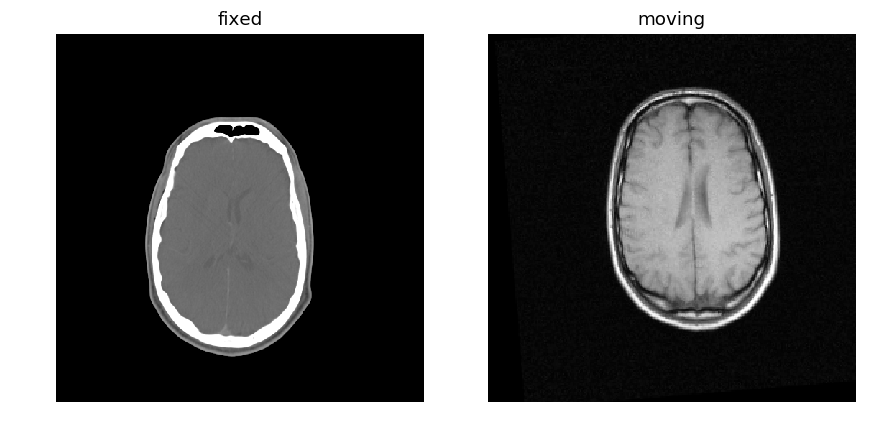

In [3]:
fixed_image =  sitk.ReadImage(fdata("training_001_ct.mha"), sitk.sitkFloat32)
moving_image = sitk.ReadImage(fdata("training_001_mr_T1.mha"), sitk.sitkFloat32)

ct_window_level = [835,162]
mr_window_level = [1036,520]

gui.MultiImageDisplay(image_list = [fixed_image, moving_image],                   
                      title_list = ['fixed', 'moving'], figure_size=(8,4), window_level_list=[ct_window_level, mr_window_level]);

## Classic Registration

Estimate a 3D **rigid** transformation between images of different modalities.

We have made the following choices with respect to initialization and registration component settings:

<ul>
<li> Similarity metric, mutual information (Mattes MI):
<ul>
  <li>Number of histogram bins, 40,</li>
  <li>Sample strategy, random,</li>
  <li>Sample percentage, 1%.</li>
</ul>
</li>
<li>Interpolator, sitkLinear.</li>
<li>Optimizer, gradient descent: 
<ul>
  <li>Learning rate, step size along traversal direction in parameter space, 1.0 .</li>
  <li>Number of iterations, maximal number of iterations, 100.</li>
  <li>Convergence minimum value, value used for convergence checking in conjunction with the energy profile of the similarity metric that is estimated in the given window size, 1e-6.</li>
  <li>Convergence window size, number of values of the similarity metric which are used to estimate the energy profile of the similarity metric, 10.</li>
</ul>
</li>
</ul>

We initialize registration by aligning the center of the two volumes. To qualitatively evaluate the result we use a linked cursor approach: click on one image and the corresponding point is added to the other image.

<IPython.core.display.Javascript object>


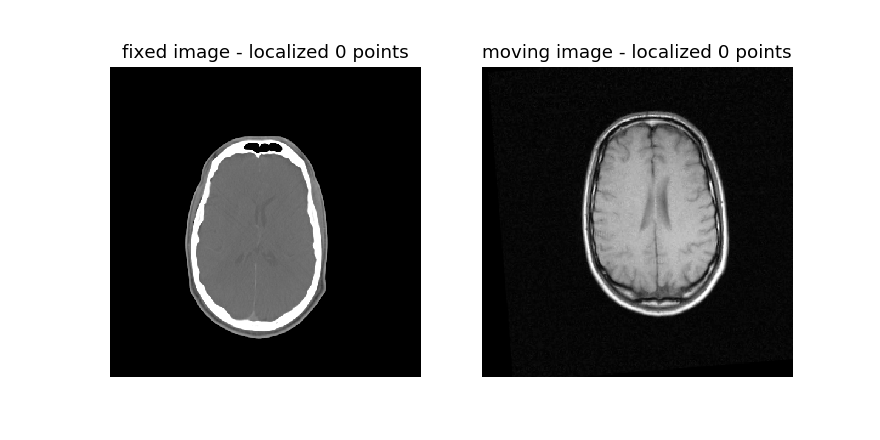

In [4]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

gui.RegistrationPointDataAquisition(fixed_image, moving_image, figure_size=(8,4), known_transformation=initial_transform, fixed_window_level=ct_window_level, moving_window_level=mr_window_level);

Run the next cell three times:
1. As is.
2. Uncomment the automated optimizer scale setting so that a change in rotation (radians) has a similar effect to a change in translation (mm).
3. Uncomment the multi-resolution settings.

<IPython.core.display.Javascript object>


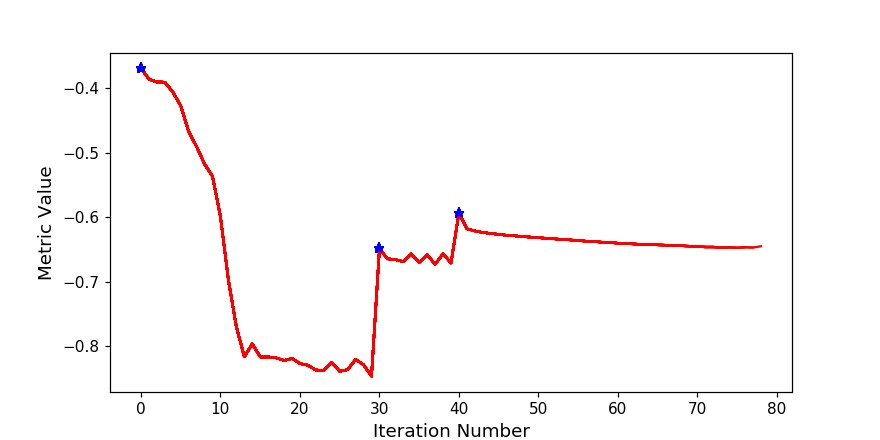

Final metric value: -0.6441626583794308
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 39.


In [5]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, rgui.start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, rgui.end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, rgui.update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rgui.plot_values(registration_method))

final_transform = registration_method.Execute(fixed_image, moving_image)

# Always check the reason optimization terminated.
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

<IPython.core.display.Javascript object>


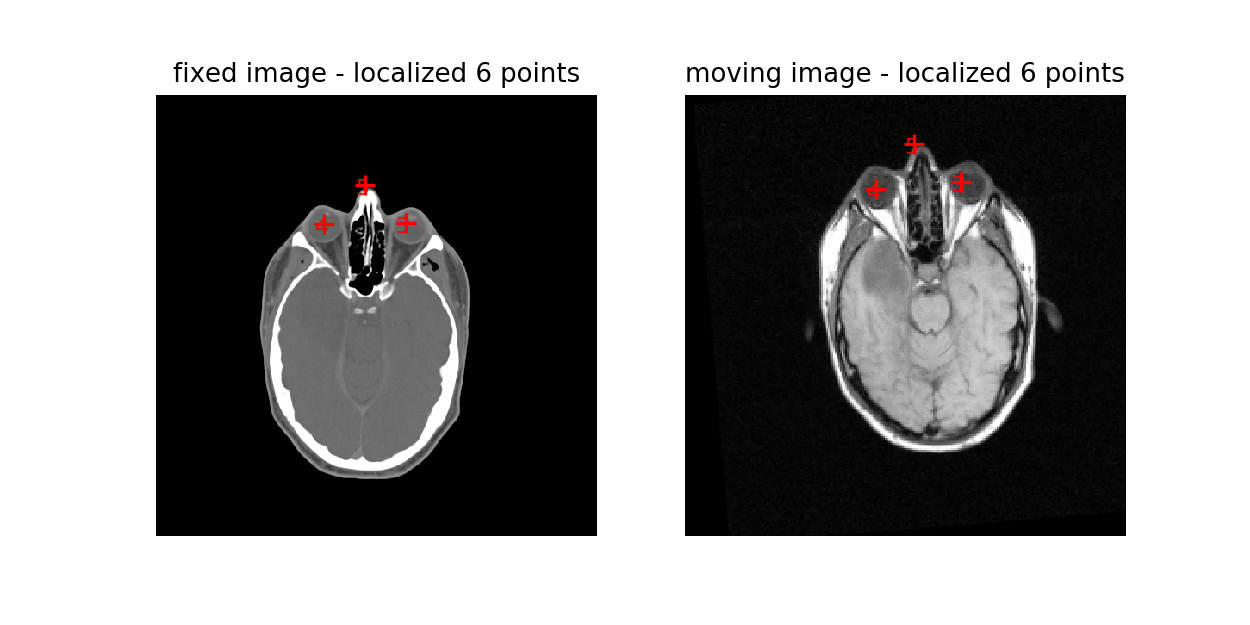

In [10]:
gui.RegistrationPointDataAquisition(fixed_image, moving_image, figure_size=(8,4), known_transformation=final_transform,fixed_window_level=ct_window_level, moving_window_level=mr_window_level);

If we are satisfied with the results, save them to file.

In [6]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
sitk.WriteImage(moving_resampled, os.path.join(OUTPUT_DIR, 'RIRE_training_001_mr_T1_resampled.mha'))
sitk.WriteTransform(final_transform, os.path.join(OUTPUT_DIR, 'RIRE_training_001_CT_2_mr_T1.tfm'))
print(final_transform)

itk::simple::Transform
 CompositeTransform (000001E70BFD8BE0)
   RTTI typeinfo:   class itk::CompositeTransform<double,3>
   Reference Count: 1
   Modified Time: 369807
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (000001E70E083BD0)
     RTTI typeinfo:   class itk::Euler3DTransform<double>
     Reference Count: 1
     Modified Time: 369411
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.99722 0.0735709 -0.0117763 
       -0.0737012 0.997219 -0.0110413 
       0.0109313 0.0118786 0.99987 
     Offset: [7.0621, -19.9446, -25.1916]
     Center: [166.994, 166.994, 56]
     Translation: [18.2243, -33.3349, -21.3898]
     Inverse: 
       0.99722 -0.0737012 0.0109313 
       0.0735709 0.997219 0.0118786 
       -0.0117763 -0.0110413 0.99987 
     Singular: 0
     Euler's angles: AngleX=0.0118789 AngleY=-0.0109323 AngleZ=-0.0736426
     m_ComputeZYX = 0
   End of Multi